# Punch-through reinforced concrete slab test

Axi symmetric finite-element idealization

In [1]:
from ibvpy.bcond import BCSlice
from ibvpy.fets import FETS2D4Q
from ibvpy.tmodel.mats3D import MATS3DElastic, MATS3DScalarDamage
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from mayavi import mlab
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym

import numpy as np

## Current state of PTRCS - FE implementation
 * Setting up the discretization

## Todo 
 * Prototyping the FE-discretization 
 * With a prototyped discretization, setup an InteractiveModel class
 * Provide the plotting of stress resultants -- verify
 * Insert a scalar damage function with a hardening response
 * Adapt the boundary conditions - rotation fixed and normal force = 1
 * Extract the stress resultants at the transition cross section (speciman radius)

In [2]:
from bmcs_expsim.utils.mlab_decorators import decorate_figure

# Define the descretization parameters

In [3]:
inner_radius = 0
outer_radius = 500
height = 150
n_elems = (4, 8)

xmodel = XDomainFEGridAxiSym(coord_min=(0,inner_radius),
                             coord_max=(height,outer_radius),
                             shape=n_elems,
                             integ_factor=2 * np.pi,
                             fets=FETS2D4Q())

# Material model specification

In [4]:
tmodel = MATS3DElastic(E=28e+5, nu=0.3)
#tmodel = MATS3DScalarDamage(E=28e+5, nu=0.3)

# Boundary conditions

In [9]:
w_max = 0.1 # mm
F_max = 1e+5
bc_ax_sym = BCSlice(slice=xmodel.mesh[:, 0, :, 0],
                 var='u', dims=[1], value=0)
bc_fixed_outer_ring = BCSlice(slice=xmodel.mesh[:, -1, :, -1],
                  var='u', dims=[0,1], value=0.0)
bc_disp_load = BCSlice(slice=xmodel.mesh[0, 0, 0, :],
                       var='u', dims=[0], value=F_max)

# Nonliner time-stepping model

In [10]:
m = TStepBC(
    domains=[(xmodel, tmodel)],
    bc=[bc_ax_sym, bc_fixed_outer_ring, bc_disp_load] # , bc_r_y],
)

m.hist.vis_record = {
    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'damage': Vis3DStateField(var='omega_a'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

In [11]:
w_steps = 10
s = m.sim
s.tloop.k_max = 400
s.tline.step = 1 / w_steps
s.tloop.verbose = True
s.run()

t:	 0.00

AttributeError: 'NoneType' object has no attribute 'r_pnt'

In [15]:
F_to = m.hist.F_t
U_to = m.hist.U_t

In [16]:
#F_l_t = np.sum(F_to[:, bc_l_x.dofs], axis=-1)
F_r_t = np.sum(F_to[:, bc_disp_load.dofs], axis=-1)
U_r_t = np.average(U_to[:, bc_disp_load.dofs], axis=-1)
F_fixed_outer_ring = np.sum(F_to[:, bc_fixed_outer_ring.dofs], axis=-1)
A = np.pi * outer_radius**2

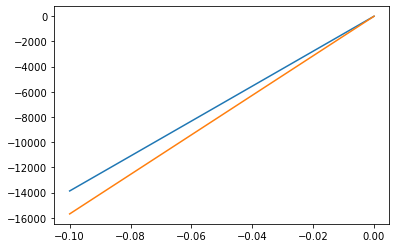

In [17]:
import matplotlib.pylab as plt
plt.plot(-U_r_t, -F_r_t/1000)
plt.plot(-U_r_t, F_fixed_outer_ring/1000)

In [18]:
#mlab.options.backend = 'envisage'

f_strain = mlab.figure()
scene = mlab.get_engine().scenes[-1]
scene.name = 'strain'
strain_viz = Viz3DTensorField(vis3d=m.hist['strain'])
strain_viz.setup()

decorate_figure(f_strain, strain_viz, 200, [70, 20, 0])

f_stress = mlab.figure()
scene = mlab.get_engine().scenes[-1]
scene.name = 'stress'
stress_viz = Viz3DTensorField(vis3d=m.hist['stress'])
stress_viz.setup()

decorate_figure(f_stress, stress_viz, 200, [70, 20, 0])

mlab.show()